In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
import shap
import os
from sklearn import preprocessing
import xgboost as xgb
import gc
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
SEED=4242

In [3]:
def get_df(df_path, dtypes_path):
    path = '../input/ieee-cis-data/'
    df_dtypes = pd.read_csv(path + dtypes_path)
    df_dtypes = df_dtypes.rename(columns={'TransactionID': 'col','int32': 'type'})
    df_dtypes = df_dtypes.to_dict(orient='records')
    new_dtypes = dict()
    for rec in df_dtypes:
        new_dtypes[rec['col']] = rec['type']
    new_dtypes['TransactionID'] = 'int32'

    df = pd.read_csv(path+df_path, dtype=new_dtypes)
    del df_dtypes, new_dtypes
    gc.collect()
    return df

def get_adverarial_val_set(X_train, X_test):
    X_test.drop(["target"], 1,inplace=True)

    train, val = X_train[X_train.probas < 0.9], X_train[X_train.probas > 0.9]
    del X_train
    gc.collect()
    
    train = train.drop(["probas"], 1)
    val = val.drop(["probas"], 1)

    X_train, y_train = train.drop("target", 1), train.target
    del train
    gc.collect()
    
    X_val, y_val = val.drop("target", 1), val.target
    del val
    gc.collect()
    
    print("Train shape: {}\nValidation shape: {}\nTest shape: {}".format(X_train.shape, X_val.shape, X_test.shape))
    
    return X_train, y_train, X_val, y_val, X_test

def get_adversarial_train(X_train, Y_train, X_test):
    X_train['target'] = Y_train
    X_test['target'] = 0
    
    X_train["is_test"] = 0
    X_test["is_test"] = 1
    assert(np.all(X_train.columns == X_test.columns))
    
    total = pd.concat([X_train, X_test])
    
    del X_train, X_test
    gc.collect()
    
    X_split = total.drop(["is_test", "target"], axis = 1)
    y_split = total.is_test
    
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_split,y_split, test_size=0.2, random_state=SEED)
    del X_split,y_split
    gc.collect()
    
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    del X_train, y_train
    gc.collect()
    
    dval = xgb.DMatrix(data=X_valid, label=y_valid)
    del X_valid, y_valid
    gc.collect()

    params ={
        'max_depth':9,
        'learning_rate':0.05,
        'subsample':0.9,
        'colsample_bytree':0.9,
        'tree_method': 'gpu_hist',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 42,
    }
    
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    clf = xgb.train(dtrain=dtrain,
                                   num_boost_round=300, evals=watchlist,
                                   early_stopping_rounds=50,
                                   verbose_eval=100, params=params)
    del watchlist, dtrain, dval
    gc.collect()
    
    feature_imp = pd.DataFrame(sorted(zip(clf.get_score().keys(), clf.get_score().values())), columns=['Feature','Value'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
    plt.title('LightGBM Features')
    plt.tight_layout()
    
    X_train = total[total.is_test == 0]
    X_test = total[total.is_test == 1]
    
    del total
    gc.collect()
    
    X_train.drop(['is_test'], 1,inplace=True)
    X_test.drop(['is_test'], 1,inplace=True)
    dval = xgb.DMatrix(data=X_train.drop(['target'],1))
    X_train['probas'] = clf.predict(dval)
    del dval
    gc.collect()
    
    X_train.sort_values(["probas"], ascending = False, inplace=True)
    
    del clf
    gc.collect()
    
    return X_train, X_test

In [4]:
train = get_df('train.csv', 'train_dtypes.csv')
test = get_df('test.csv', 'test_dtypes.csv')
sub = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [5]:
# one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
# one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
# many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
# many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]
# big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
# big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
# skewed_cols = [col for col in train.columns if train[col].value_counts(normalize=True).values[0] > 0.95]
# skewed_cols_test = [col for col in test.columns if test[col].value_counts(normalize=True).values[0] > 0.95]
# cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + skewed_cols + skewed_cols_test+
#                         big_top_value_cols_test + one_value_cols+ one_value_cols_test))
# cols_to_drop.remove('isFraud')

# train = train.drop(cols_to_drop, axis=1)
# test = test.drop(cols_to_drop, axis=1)
# gc.collect()

In [6]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]
gc.collect()

14

In [7]:
X = X[X_test.columns]

In [8]:
object_columns = list(X.select_dtypes('object').columns)
for f in object_columns:
    le = preprocessing.LabelEncoder()
    le.fit(list(X[f].values)+list(X_test[f].values))
    X[f] = le.transform(list(X[f].values))
    X_test[f] = le.transform(list(X_test[f].values))

In [9]:
to_drop = [
    'id_31',
#     'D15',
#     'D10','card1','C13','D4','card2','D11','addr1','D1','dist1','D2','TransactionAmt', 
#     'C9', 'C11'

    #     'C9','C11','D5','C1','C14','C2','card5','C6','D3','V310','D6','C5','V130','D8','P_emaildomain','D14','id_30','C12',
#     'id_20','id_13','D13','id_02'
]

In [10]:
dataX_tr = X.drop(to_drop, 1)
dataX_te = X_test.drop(to_drop, 1)
gc.collect()

7

Concat
Split
Train
[0]	train-auc:0.851904	val-auc:0.852939
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 50 rounds.
[100]	train-auc:0.888475	val-auc:0.887757
[200]	train-auc:0.908496	val-auc:0.905371
[299]	train-auc:0.920997	val-auc:0.916002
Extract


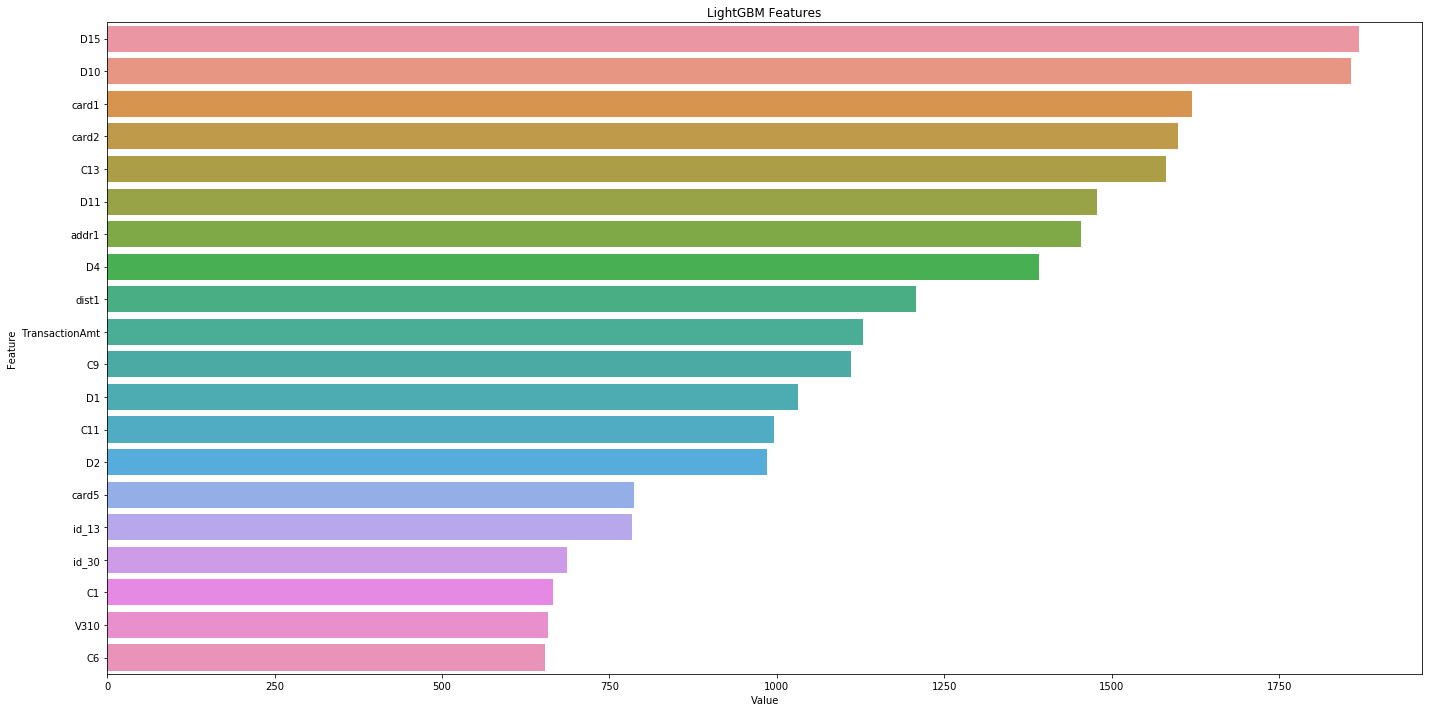

In [11]:
dataX_train, dataX_test = get_adversarial_train(dataX_tr, y_train, dataX_te)

In [12]:
X_train, y_train, X_valid, y_valid, X_test = get_adverarial_val_set(dataX_train, dataX_test)

Train shape: (589082, 430)
Validation shape: (1458, 430)
Test shape: (506691, 430)


In [13]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
del X_train, y_train
gc.collect()

dval = xgb.DMatrix(data=X_valid, label=y_valid)
del X_valid, y_valid
gc.collect()

params ={
    'max_depth':9,
    'learning_rate':0.05,
    'subsample':0.9,
    'colsample_bytree':0.9,
    'tree_method': 'gpu_hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
clf = xgb.train(dtrain=dtrain,
                               num_boost_round=3000, evals=watchlist,
                               early_stopping_rounds=300,
                               verbose_eval=100, params=params)

[0]	train-auc:0.846255	val-auc:0.836843
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 300 rounds.
[100]	train-auc:0.945204	val-auc:0.919385
[200]	train-auc:0.969553	val-auc:0.931114
[300]	train-auc:0.977815	val-auc:0.931951
[400]	train-auc:0.983473	val-auc:0.930706
[500]	train-auc:0.987513	val-auc:0.931522
Stopping. Best iteration:
[222]	train-auc:0.97172	val-auc:0.933659



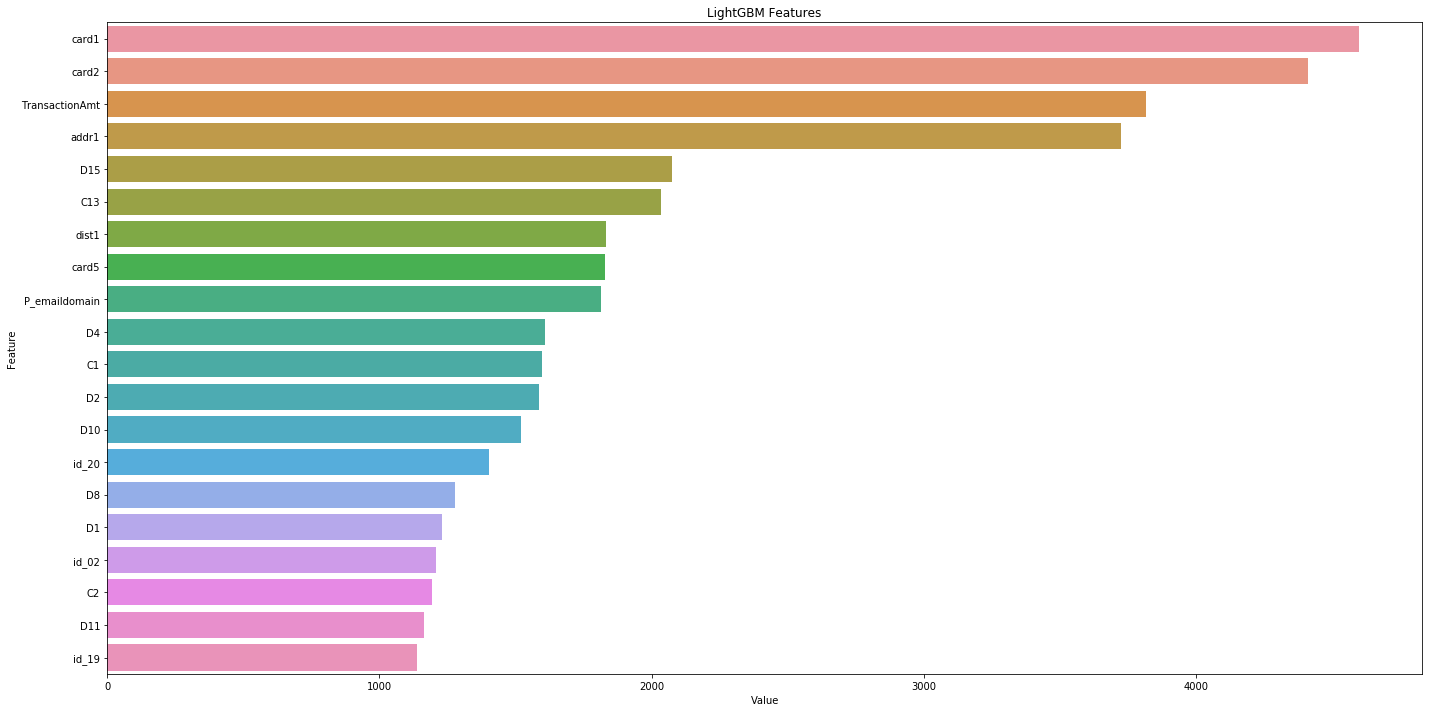

In [14]:
feature_imp = pd.DataFrame(sorted(zip(clf.get_score().keys(), clf.get_score().values())), columns=['Feature','Value'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()


In [15]:
dtest = xgb.DMatrix(data=X_test)
test = test.sort_values('TransactionDT')
test['prediction'] = clf.predict(dtest)
sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
sub.to_csv('adv.csv', index=False)

In [16]:
sub.tail()

,TransactionID,isFraud
506686,4170235,0.015175
506687,4170236,0.004786
506688,4170237,0.006766
506689,4170238,0.012632
506690,4170239,0.009307
